In [38]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numba


%matplotlib inline

ImportError: cannot import name 'structref' from 'numba.experimental' (C:\Users\MAYANK MONANI\anaconda3\lib\site-packages\numba\experimental\__init__.py)

In [2]:
# movie titles
mv_genres = pd.read_csv("../ml-latest/ml-latest/movies.csv")

In [3]:
# movie tags
mv_tags = pd.read_csv("../ml-latest/ml-latest/genome-scores.csv")

In [4]:
# movie tag descriptions
mv_tags_desc = pd.read_csv("../ml-latest/ml-latest/genome-tags.csv")

In [5]:
# clean title in movies.csv file

def movie_title_clean(title):
    
    #     search title for (year) pattern
    s = re.search('\(([^)]+)', title)
    # if pattern exists, remove from string
    year = 9999
    if s:
        title = title[:s.span()[0]].strip()
        year = s.group(1)

    #     check if year is actual year
    if str(year).isdigit():
        year = int(year)
    else:
        year = 9999
    
# if ', The' or ', A' is a the end of the string, move it to the front
  # e.g. change "Illusionist, The" to "The Illusionist"
    
    if title[-5:] == ', The':
        title = 'The ' + title[:-5]
    elif title[-4:] == ', An':
        title = 'An ' + title[:-4]
    elif title[-3:] == ', A':
        title = 'A ' + title[:-3]

    return title, year

In [6]:
# clean title and extract release year
mv_genres["title"] = mv_genres["title"].str.strip()
mv_genres["Title_Year"] = mv_genres["title"].map(movie_title_clean)
mv_genres["Title"] = mv_genres["Title_Year"].apply(lambda x: x[0])
mv_genres["Release Year"] = mv_genres["Title_Year"].apply(lambda x: x[1])

In [7]:
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995


In [8]:
# create binary indicators for each genre

mv_genres_stack = mv_genres[mv_genres["genres"] != "(no genres listed)"].set_index("movieId").genres.str.split("|", expand = True).stack()
mv_genres_explode = pd.get_dummies(mv_genres_stack, prefix="g").groupby(level=0).sum().reset_index()
del mv_genres_stack

In [9]:
# genre vector (binary string)
mv_genres_explode["genre_vector"] = mv_genres_explode.iloc[:, 1:].values.tolist()

In [10]:
# check out genre vector
mv_genres_explode.head()

,movieId,g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Fantasy,...,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,genre_vector
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
# append genre vector
mv_genres = mv_genres.merge(mv_genres_explode[['movieId','genre_vector']], on = 'movieId', how = 'left')

In [12]:
# check out genre dataframe with genre vector
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year,genre_vector
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
# How many tags do we need or each movie??

In [14]:
# nmber of tags
len(np.unique(mv_tags_desc.tagId.values))

1128

In [15]:
# number of movies
len(np.unique(mv_tags.movieId.values))

13176

In [16]:
# number of movie, tag pairs
len(mv_tags)

14862528

In [17]:
# join dataframes to get tag description and movie title name all in one table
mv_tags_denorm = mv_tags.merge(mv_tags_desc, on = 'tagId').merge(mv_genres, on = 'movieId')

# for each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
mv_tags_denorm['relevance_rank'] = mv_tags_denorm.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')

In [18]:
# check out an example of top tags for a movie
mv_tags_denorm[mv_tags_denorm.Title == 'Remember the Titans'][['movieId','Title','tag','relevance','relevance_rank']].sort_values(by = 'relevance', ascending = False).head(10)

,movieId,Title,tag,relevance,relevance_rank
3958984,3916,Remember the Titans,race issues,0.99550,1
3958551,3916,Remember the Titans,football,0.99275,2
3959110,3916,Remember the Titans,sports,0.98550,3
3958266,3916,Remember the Titans,based on true story,0.96125,4
3959049,3916,Remember the Titans,segregation,0.95425,5
3958654,3916,Remember the Titans,high school,0.95075,6
3958538,3916,Remember the Titans,feel good movie,0.94975,7
3958261,3916,Remember the Titans,based on a true story,0.94725,8
3958700,3916,Remember the Titans,inspiring,0.94150,9
3958539,3916,Remember the Titans,feel-good,0.93500,10


In [19]:
# compute median relevance score for each relevance rank
mv_tags_rank_agg = mv_tags_denorm.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)

# compute percent change of median relevance score as we go down in rank
mv_tags_rank_agg['relevance_median_pct_chg'] = mv_tags_rank_agg['relevance_median'].pct_change()

Text(0.5, 1.0, 'Box Plot: Tag Relevance Score by Rank')

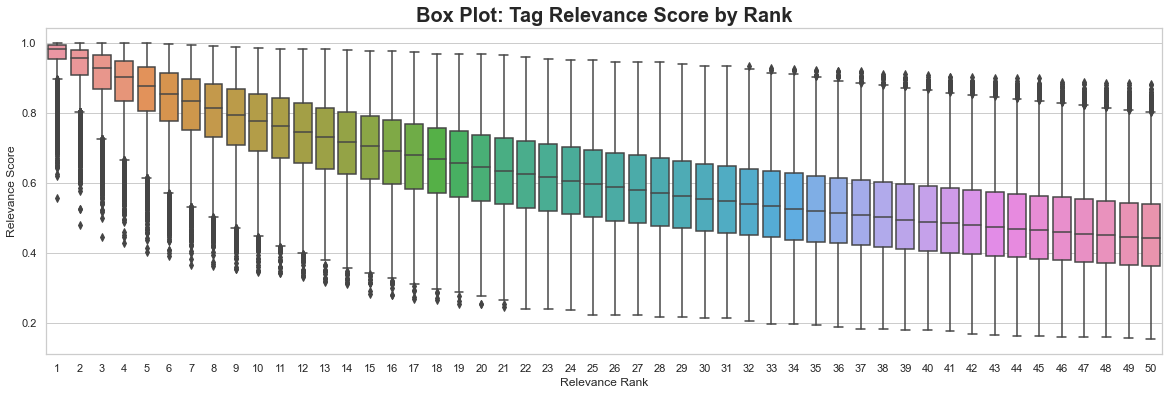

In [20]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(20, 6))

ax = sns.boxplot(x = "relevance_rank", y = "relevance", data = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 50], showfliers = True)
ax.set(ylabel = "Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("Box Plot: Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

Text(0.5, 1.0, '% Change in Tag Relevance Score by Rank')

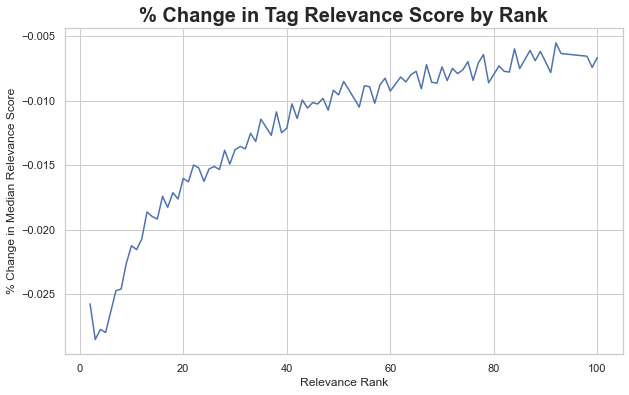

In [21]:
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = mv_tags_rank_agg)
ax.set(ylabel = "% Change in Median Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("% Change in Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

In [22]:
# flatten tags table to get a list of top 100 tags for each movie
mv_tags_list = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 100].groupby(['movieId','Title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
mv_tags_list['tag_list'] = mv_tags_list.tag.map(lambda x: x.split(','))

In [23]:
mv_tags_list.head(1)

,movieId,Title,tag,tag_list
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...","[3d, action, adventure, affectionate, animal m..."


In [24]:
# compute Jaccard Index to get most similar movies to target movie

pd.reset_option('display.max_colwidth')

target_movie = 'Interstellar'

target_tag_list = mv_tags_list[mv_tags_list.Title == target_movie].tag_list.values[0]
mv_tags_list_sim = mv_tags_list[['movieId','Title','tag_list','tag']]
mv_tags_list_sim['jaccard_sim'] = mv_tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
print(f'Movies most similar to {target_movie} based on tags:')
text = ','.join(mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(10)

Movies most similar to Interstellar based on tags:


<ipython-input-24-b91a6e73d2a8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv_tags_list_sim['jaccard_sim'] = mv_tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))


,movieId,Title,tag_list,tag,jaccard_sim
11703,109487,Interstellar,"[70mm, adventure, amazing photography, astrona...","70mm,adventure,amazing photography,astronauts,...",1.000000
8826,52328,Sunshine,"[alien, aliens, allegory, apocalypse, astronau...","alien,aliens,allegory,apocalypse,astronauts,at...",0.526718
1475,1653,Gattaca,"[1950s, allegory, alone in the world, alternat...","1950s,allegory,alone in the world,alternate re...",0.481481
12868,164179,Arrival,"[alien, alien invasion, aliens, allegory, atmo...","alien,alien invasion,aliens,allegory,atmospher...",0.470588
1412,1584,Contact,"[adapted from:book, adventure, alien, alien in...","adapted from:book,adventure,alien,alien invasi...",0.459854
11522,104841,Gravity,"[3d, action, allegory, amazing cinematography,...","3d,action,allegory,amazing cinematography,amaz...",0.459854
12337,134130,The Martian,"[adaptation, adapted from:book, adventure, ali...","adaptation,adapted from:book,adventure,alien,a...",0.449275
9705,68237,Moon,"[allegory, artificial intelligence, astronauts...","allegory,artificial intelligence,astronauts,at...",0.449275
11359,101864,Oblivion,"[action, adapted from:comic, adventure, alien,...","action,adapted from:comic,adventure,alien,alie...",0.449275
12918,166635,Passengers,"[action, adventure, allegory, alternate ending...","action,adventure,allegory,alternate endings,an...",0.449275


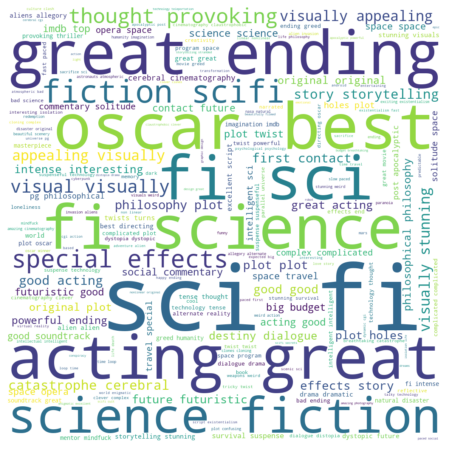

In [25]:
plt.rcParams["figure.figsize"] = (15,10)

# Generate a word cloud image
wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'white').generate(text)

# Display the generated image:
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
# corpus of movie tags
mv_tags_corpus = mv_tags_list.tag.values

In [27]:
stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
  tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
  tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
  return tokens

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\MAYANK
[nltk_data]     MONANI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
# preprocess corpus of movie tags before feeding it into Doc2Vec model
mv_tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(mv_tags_corpus)]

In [30]:
# instantiate Doc2Vec model

max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
               alpha=alpha, min_alpha=0.00025,
               min_count=1, dm=0) #paragraph vector distributor

model.build_vocab(mv_tags_doc)

C:\Users\MAYANK MONANI\anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [31]:
#  train Doc2Vec model
# stochastic (random initialization), so each run will be different unless you specify seed

print('Epoch', end = ': ')
for epoch in range(max_epochs):
  print(epoch, end = ' ')
  model.train(mv_tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
  # decrease the learning rate
  model.alpha -= 0.0002
  # fix the learning rate, no decay
  model.min_alpha = model.alpha

Epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [32]:
# listing space embeddings
mv_tags_vectors = model.docvecs.vectors_docs

In [33]:
mv_tags_vectors.shape

(13176, 20)

In [34]:
# top similar movies based on cosine similarity

mv = 'Good Will Hunting'

mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]

print(mv_tags_vectors[mv_index])

sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
  print(mv_tags_list.loc[int(i), "Title"].strip())

[-1.7720953   0.75047535  0.36769366 -1.210274   -0.49286845 -0.690407
  0.8022294   1.269241    1.2344899  -0.96859103  0.10427762 -0.8321694
  1.1095496  -0.43530473  0.24729952  0.39040366  0.6079139  -0.62513775
 -0.97201246  0.2530987 ]
Almost Famous
Dead Poets Society
Children of a Lesser God
A Beautiful Mind
The Big Chill
Rain Man
Finding Forrester
Steve Jobs
Genius
Educating Rita
Little Man Tate
The Truman Show
Mr. Holland's Opus
Danny Collins
The Paper Chase
St. Vincent
Up in the Air
The Theory of Everything
On Golden Pond
American Beauty
Wonder Boys
Charly
Pay It Forward
Me Myself I
Stand and Deliver
Sideways
Starting Out in the Evening
Boyhood
Nothing in Common
Love & Mercy


In [35]:
import umap

ImportError: cannot import name 'structref' from 'numba.experimental' (C:\Users\MAYANK MONANI\anaconda3\lib\site-packages\numba\experimental\__init__.py)